# Sorting Benchmark — Analysis Notebook

This notebook cleans and analyzes the results generated fomr benchmatk.py

### What it does
- Loads csv file 
- Writes a clean copy to results
- Create a group summary in
- Creates matplotlib plots 


In [1]:

import os, io
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

RAW_PATH = Path('results/benchmark_raw_runs.csv')   
CLEAN_PATH = Path('results/benchmark_raw_runs_clean.csv')
SUMMARY_PATH = Path('results/benchmark_summary.csv')
CLEAN_PATH.parent.mkdir(parents=True, exist_ok=True)
RAW_PATH, CLEAN_PATH, SUMMARY_PATH


(WindowsPath('results/benchmark_raw_runs.csv'),
 WindowsPath('results/benchmark_raw_runs_clean.csv'),
 WindowsPath('results/benchmark_summary.csv'))

## 1) Load CSV file

In [2]:

def load_raw_csv_robust(path: Path) -> pd.DataFrame:
    txt = path.read_text(encoding='utf-8', errors='ignore')
    lines = txt.splitlines()
    header_idx = None
    for i, s in enumerate(lines):
        if s.strip().lower().startswith('algorithm,'):
            header_idx = i
            break
    if header_idx is None:
        raise RuntimeError("could not find header line")
    core = "\n".join(lines[header_idx:])
    return pd.read_csv(io.StringIO(core))

# load the raw file
df = load_raw_csv_robust(RAW_PATH)
print(f"Loaded {len(df)} rows with columns: {list(df.columns)}")
df.head(10)


Loaded 350 rows with columns: ['algorithm', 'size', 'distribution', 'trial', 'runtime_sec', 'cpu_avg_percent', 'cpu_peak_percent', 'rss_peak_delta_bytes', 'py_heap_peak_bytes', 'correct']


,algorithm,size,distribution,trial,runtime_sec,cpu_avg_percent,cpu_peak_percent,rss_peak_delta_bytes,py_heap_peak_bytes,correct
0,Bubble,1000,random,1,0.555404,92.644444,133.0,176128,13313,True
1,Bubble,1000,random,2,0.493933,100.062500,100.8,20480,12537,True
2,Bubble,1000,random,3,0.493380,96.962500,100.8,20480,12537,True
3,Bubble,1000,random,4,0.490257,101.212500,133.0,20480,12513,True
4,Bubble,1000,random,5,0.491323,97.925000,133.0,20480,12777,True
5,Merge,1000,random,1,0.004699,0.000000,0.0,0,21886,True
6,Merge,1000,random,2,0.004356,0.000000,0.0,0,20622,True
7,Merge,1000,random,3,0.004342,0.000000,0.0,0,20590,True
8,Merge,1000,random,4,0.004224,0.000000,0.0,0,20566,True
9,Merge,1000,random,5,0.004281,0.000000,0.0,0,20543,True


## 2)Confirm columns

In [3]:

expected = ['algorithm','size','distribution','trial','runtime_sec',
            'cpu_avg_percent','cpu_peak_percent','rss_peak_delta_bytes',
            'py_heap_peak_bytes','correct']

missing = [c for c in expected if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing columns: {missing}")
print("all columns look good ✅")



all columns look good ✅


## 3) Save file

In [4]:

df.to_csv(CLEAN_PATH, index=False, encoding='utf-8')
print(f"Cleaned CSV written to: {CLEAN_PATH.resolve()}")


Cleaned CSV written to: C:\Users\tanam\OneDrive\Desktop\Computer Science Thesis\Thesis code\results\benchmark_raw_runs_clean.csv


## 4) Checks 

In [5]:

print("Algorithms:", sorted(df['algorithm'].unique()))
print("Sizes     :", sorted(df['size'].unique()))
print("Dists     :", sorted(df['distribution'].unique()))
print("Repeats   :", df.groupby(['algorithm','size','distribution']).size().head(8))
print("All correct? ->", bool(df['correct'].all()))


Algorithms: ['Bubble', 'Merge', 'Quick', 'TimSort']
Sizes     : [1000, 10000, 100000, 1000000]
Dists     : ['disorder10', 'disorder50', 'duplicates', 'random', 'reversed']
Repeats   : algorithm  size   distribution
Bubble     1000   disorder10      5
                  disorder50      5
                  duplicates      5
                  random          5
                  reversed        5
           10000  disorder10      5
                  disorder50      5
                  duplicates      5
dtype: int64
All correct? -> True


## 5) Build by-(algorithm,size,distribution) summary

In [6]:

agg = {
    'runtime_sec': ['median','mean','std'],
    'cpu_avg_percent': ['median','mean','std'],
    'cpu_peak_percent': ['median','mean','std'],
    'rss_peak_delta_bytes': ['median','mean','std'],
    'py_heap_peak_bytes': ['median','mean','std']
}
summary = (
    df
    .groupby(['algorithm','size','distribution'], as_index=False)
    .agg(agg)
)
summary.columns = ['_'.join([c for c in col if c]).rstrip('_') for col in summary.columns.values]
display(summary.head(12))

summary.to_csv(SUMMARY_PATH, index=False, encoding='utf-8')
print(f"Summary CSV written to: {SUMMARY_PATH.resolve()}")


,algorithm,size,distribution,runtime_sec_median,runtime_sec_mean,runtime_sec_std,cpu_avg_percent_median,cpu_avg_percent_mean,cpu_avg_percent_std,cpu_peak_percent_median,cpu_peak_percent_mean,cpu_peak_percent_std,rss_peak_delta_bytes_median,rss_peak_delta_bytes_mean,rss_peak_delta_bytes_std,py_heap_peak_bytes_median,py_heap_peak_bytes_mean,py_heap_peak_bytes_std
0,Bubble,1000,disorder10,0.307369,0.306271,0.001959,91.480000,91.288000,2.962148,100.8,107.24,14.400278,20480.0,20480.0,0.000000,11986.0,12061.2,168.152312
1,Bubble,1000,disorder50,0.430931,0.430571,0.001042,90.457143,90.651429,2.521532,100.8,113.68,17.636666,20480.0,20480.0,0.000000,12082.0,12200.4,220.501247
2,Bubble,1000,duplicates,0.492887,0.494381,0.003233,88.600000,88.390000,3.443000,100.8,100.80,0.000000,20480.0,20480.0,0.000000,12018.0,12102.8,203.300762
3,Bubble,1000,random,0.493380,0.504859,0.028295,97.925000,97.761389,3.318636,133.0,120.12,17.636666,20480.0,51609.6,69607.901712,12537.0,12735.4,340.418566
4,Bubble,1000,reversed,0.614580,0.614691,0.000633,95.820000,94.944000,2.904209,133.0,120.12,17.636666,20480.0,20480.0,0.000000,12082.0,12232.4,336.304624
5,Bubble,10000,disorder10,48.480343,48.230820,0.672342,100.032319,100.048612,0.153669,135.9,135.90,0.000000,20480.0,20480.0,0.000000,107611.0,107700.6,316.146801
6,Bubble,10000,disorder50,60.657930,60.727873,0.413743,100.161577,100.136068,0.111469,135.9,135.90,0.000000,20480.0,27852.8,12423.783128,114427.0,114545.4,346.844057
7,Bubble,10000,duplicates,68.247447,68.659658,1.325809,100.091327,100.102296,0.128853,135.9,138.96,6.842368,20480.0,41779.2,39116.263871,118387.0,118582.2,1259.467824
8,Bubble,10000,random,71.367746,71.546687,0.600413,100.018182,100.061095,0.151021,135.9,135.90,0.000000,98304.0,116326.4,91891.092130,119875.0,120180.6,1018.758460
9,Bubble,10000,reversed,96.408328,96.798001,0.846478,100.120679,100.073482,0.214674,135.9,135.90,0.000000,20480.0,21299.2,1831.786887,133099.0,133081.4,1122.460155


Summary CSV written to: C:\Users\tanam\OneDrive\Desktop\Computer Science Thesis\Thesis code\results\benchmark_summary.csv


## 6) Plotters

In [7]:

def plot_runtime_vs_size_for_distribution(dist: str, metric: str = 'runtime_sec_median'):
    subset = summary[summary['distribution']==dist]
    algos = sorted(subset['algorithm'].unique())
    plt.figure()
    for algo in algos:
        s = subset[subset['algorithm']==algo].sort_values('size')
        plt.plot(s['size'], s[metric], marker='o', label=algo)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('n (log scale)'); plt.ylabel(metric.replace('_',' '))
    plt.title(f"{metric} by size — {dist}")
    plt.legend(); plt.grid(True, which='both', linestyle=':')
    plt.show()

def plot_bar_at_size(n: int, metric: str = 'runtime_sec_median'):
    s = summary[summary['size']==n].copy()
    s = s.sort_values(metric)
    plt.figure()
    plt.bar(s['algorithm'] + ' | ' + s['distribution'], s[metric])
    plt.xticks(rotation=90)
    plt.ylabel(metric.replace('_',' '))
    plt.title(f"{metric} at n={n}")
    plt.tight_layout()
    plt.show()


## 7) Example charts

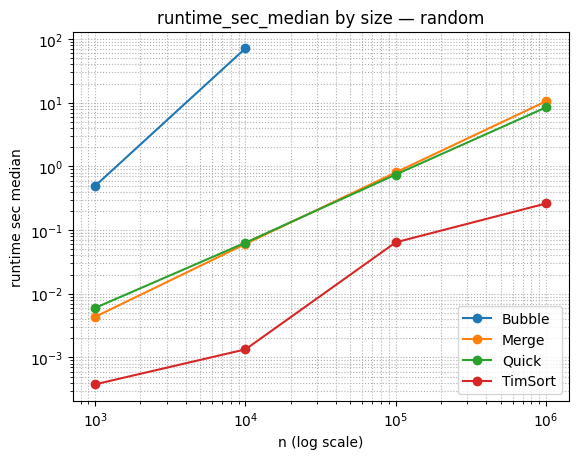

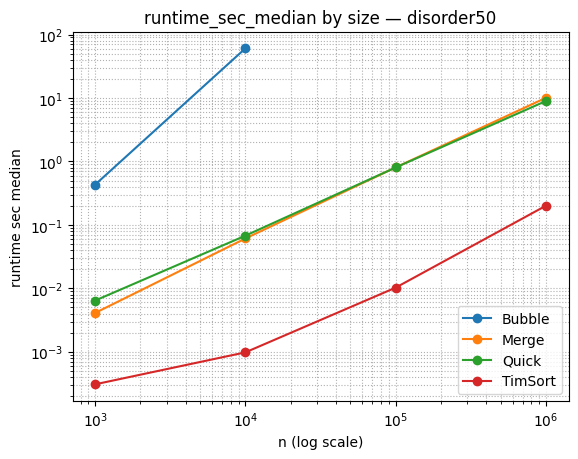

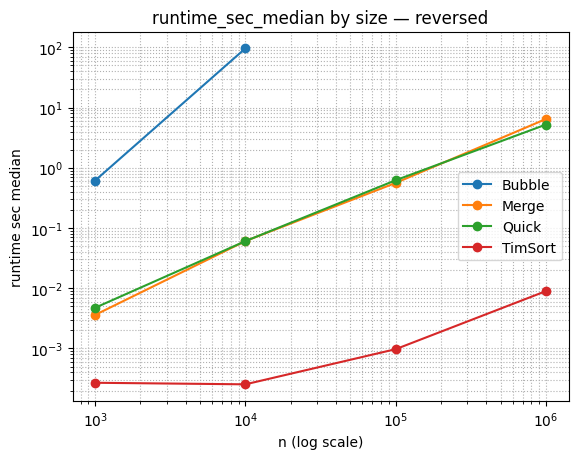

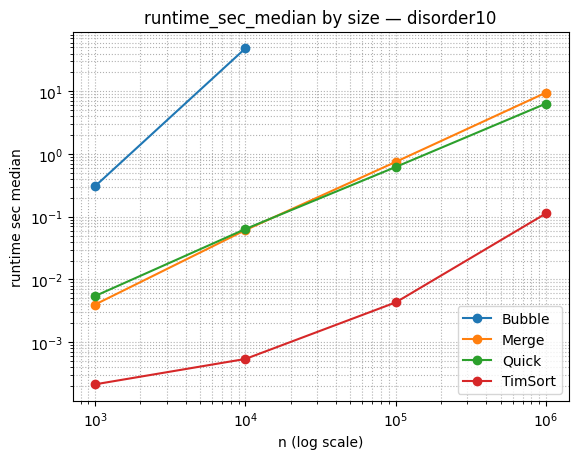

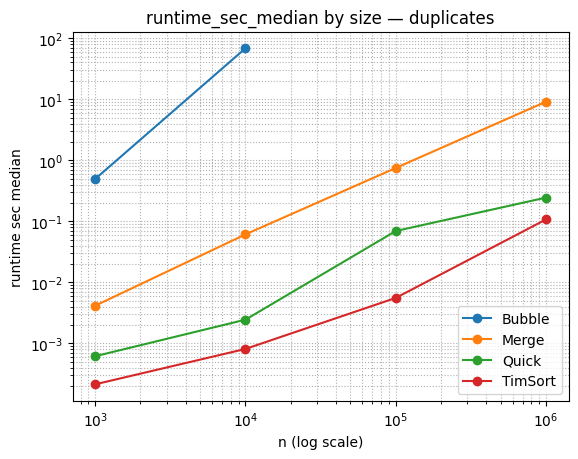

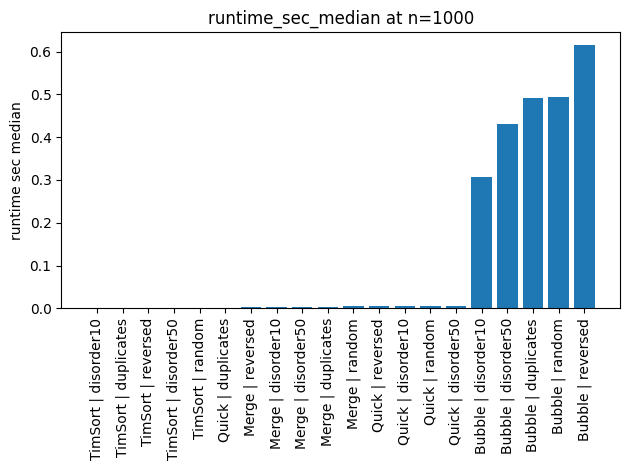

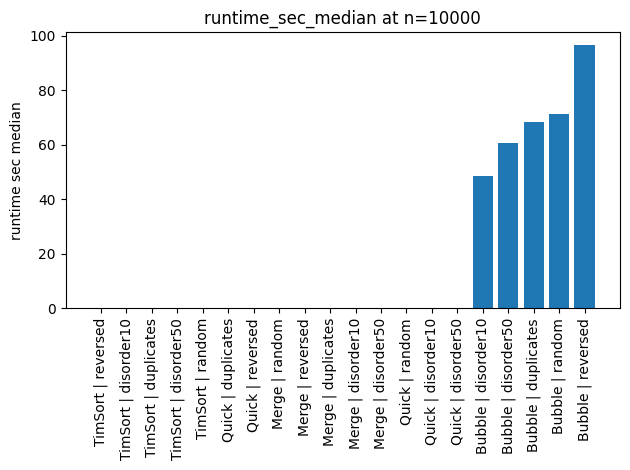

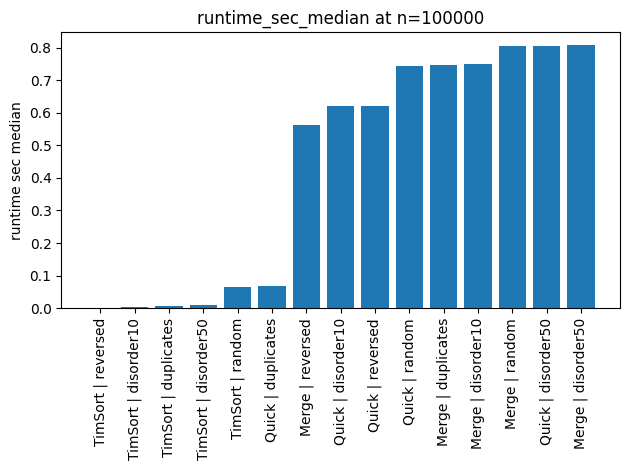

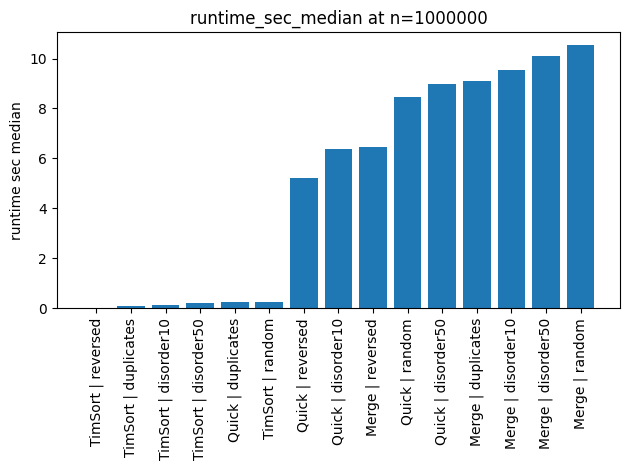

In [8]:

for d in ['random','disorder50','reversed','disorder10','duplicates']:
    if (summary['distribution']==d).any():
        plot_runtime_vs_size_for_distribution(d, 'runtime_sec_median')

for n in [1000, 10000, 100000, 1000000]:
    if (summary['size']==n).any():
        plot_bar_at_size(n, 'runtime_sec_median')


## 8) CPU and memory at the largest size present

Largest n in data: 1000000


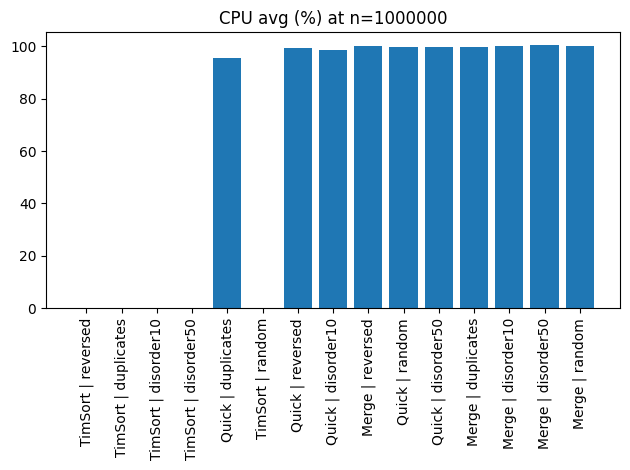

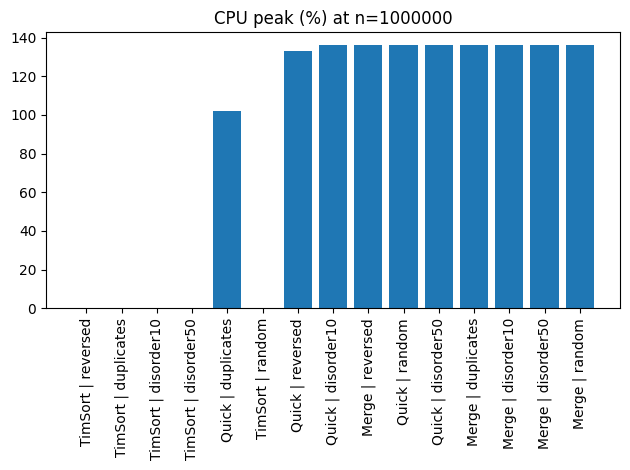

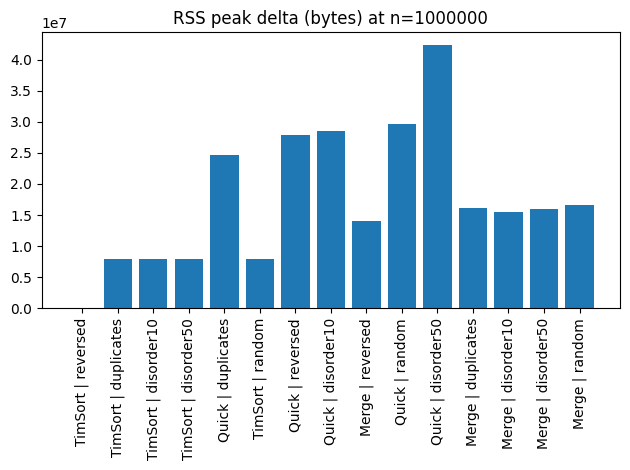

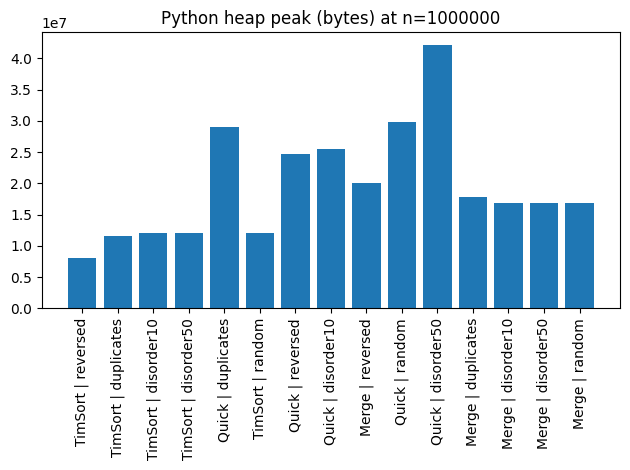

In [9]:

max_n = int(summary['size'].max())
smax = summary[summary['size']==max_n].copy().sort_values('runtime_sec_median')
print("Largest n in data:", max_n)

metrics = [
    ('cpu_avg_percent_median', 'CPU avg (%)'),
    ('cpu_peak_percent_median','CPU peak (%)'),
    ('rss_peak_delta_bytes_median','RSS peak delta (bytes)'),
    ('py_heap_peak_bytes_median','Python heap peak (bytes)')
]

for col, title in metrics:
    plt.figure()
    plt.bar(smax['algorithm'] + ' | ' + smax['distribution'], smax[col])
    plt.xticks(rotation=90)
    plt.title(f"{title} at n={max_n}")
    plt.tight_layout()
    plt.show()


## 9) Quick observations

In [10]:

def topk_at_size(n, k=5):
    s = summary[summary['size']==n].sort_values('runtime_sec_median').head(k)
    return s[['algorithm','distribution','runtime_sec_median']]
for n in sorted(summary['size'].unique()):
    print(f"n={n}: fastest (by median runtime)")
    display(topk_at_size(n))


n=1000: fastest (by median runtime)


,algorithm,distribution,runtime_sec_median
50,TimSort,disorder10,0.000212
52,TimSort,duplicates,0.000213
54,TimSort,reversed,0.000269
51,TimSort,disorder50,0.000308
53,TimSort,random,0.000379


n=10000: fastest (by median runtime)


,algorithm,distribution,runtime_sec_median
59,TimSort,reversed,0.000253
55,TimSort,disorder10,0.000540
57,TimSort,duplicates,0.000809
56,TimSort,disorder50,0.000982
58,TimSort,random,0.001339


n=100000: fastest (by median runtime)


,algorithm,distribution,runtime_sec_median
64,TimSort,reversed,0.000973
60,TimSort,disorder10,0.004303
62,TimSort,duplicates,0.005544
61,TimSort,disorder50,0.010290
63,TimSort,random,0.064183


n=1000000: fastest (by median runtime)


,algorithm,distribution,runtime_sec_median
69,TimSort,reversed,0.008964
67,TimSort,duplicates,0.107232
65,TimSort,disorder10,0.112977
66,TimSort,disorder50,0.201151
47,Quick,duplicates,0.244382
